שלב 1: טעינת הנתונים והכנות ראשוניות

In [40]:
import pandas as pd
import re
import networkx as nx

# שלב 1: טעינת הנתונים המקוריים
nodes_data = pd.read_csv('nodes.csv')
edges_data = pd.read_csv('edges.csv')

# שלב 2: ניקוי נתונים
nodes_data = nodes_data.dropna(subset=['name']).copy()

def remove_empty_lists(value):
    if isinstance(value, str) and (value == "[]" or value == ""):
        return pd.NA
    return value

columns_to_clean = ['name', 'followers', 'popularity', 'genres', 'chart_hits']
for column in columns_to_clean:
    nodes_data.loc[:, column] = nodes_data[column].apply(remove_empty_lists)

nodes_data = nodes_data.dropna().copy()

def extract_countries(chart_hits):
    if isinstance(chart_hits, str):
        countries = re.findall(r"'([a-z]{2})\s*\(\d+\)'", chart_hits)
        return ', '.join(set(countries))
    return ""

nodes_data['countries'] = nodes_data['chart_hits'].apply(extract_countries)

valid_ids = set(nodes_data['spotify_id'])

filtered_edges = edges_data[
    (edges_data['id_0'].isin(valid_ids)) &
    (edges_data['id_1'].isin(valid_ids))
]

# שמירת הנתונים המעודכנים
nodes_data.to_excel('final_cleaned_data_with_countries.xlsx', index=False)
filtered_edges.to_csv('filtered_edges.csv', index=False)

# שלב 6: יצירת הגרף
G = nx.from_pandas_edgelist(filtered_edges, 'id_0', 'id_1')

# הוספת תכונות הצמתים לגרף
for index, row in nodes_data.iterrows():
    if row['spotify_id'] in G:
        G.nodes[row['spotify_id']]['name'] = row['name']
        G.nodes[row['spotify_id']]['followers'] = row['followers']
        G.nodes[row['spotify_id']]['popularity'] = row['popularity']
        G.nodes[row['spotify_id']]['genres'] = row['genres']
        G.nodes[row['spotify_id']]['countries'] = row['countries']


Running Louvain algorithm...
Louvain Modularity: 0.7757347538302273
Running Greedy Modularity algorithm...
Greedy Modularity: 0.7018977766400992
Algorithm: Louvain, Modularity: 0.7757347538302273
Algorithm: Greedy Modularity, Modularity: 0.7018977766400992


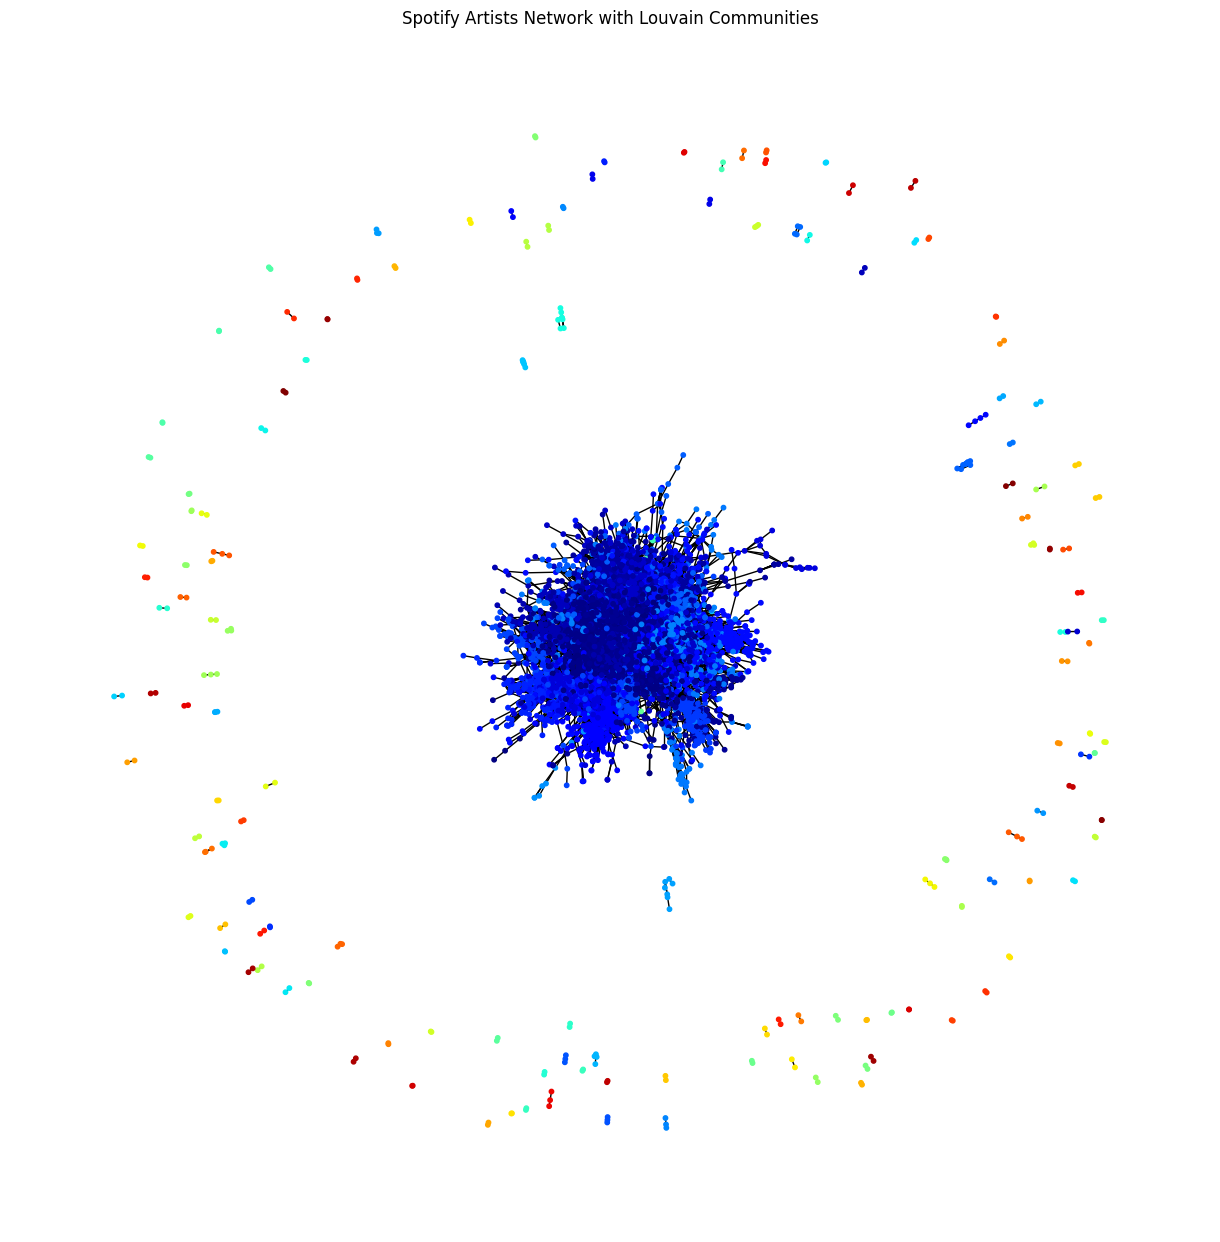

In [42]:
import community.community_louvain as community_louvain  # ייבוא נכון
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman
import matplotlib.pyplot as plt
import itertools
import networkx as nx

# פונקציה להערכת מודולריות ומדדים נוספים
def evaluate_partition(G, partition):
    modularity_score = nx.algorithms.community.quality.modularity(G, partition)
    return modularity_score

# שלב 2: Louvain Algorithm
print("Running Louvain algorithm...")
partition_louvain = community_louvain.best_partition(G)
communities_louvain = [[] for _ in range(max(partition_louvain.values()) + 1)]
for node, community in partition_louvain.items():
    communities_louvain[community].append(node)
modularity_louvain = evaluate_partition(G, communities_louvain)
print(f"Louvain Modularity: {modularity_louvain}")

# שלב 3: Greedy Modularity Algorithm
print("Running Greedy Modularity algorithm...")
communities_greedy = list(greedy_modularity_communities(G))
modularity_greedy = evaluate_partition(G, communities_greedy)
print(f"Greedy Modularity: {modularity_greedy}")

# הצגת תוצאות
results = {
    'Algorithm': ['Louvain', 'Greedy Modularity'],
    'Modularity': [modularity_louvain, modularity_greedy]
}

for i, alg in enumerate(results['Algorithm']):
    print(f"Algorithm: {alg}, Modularity: {results['Modularity'][i]}")

# הצגת הגרף עם קהילות האלגוריתם הנבחר (נניח Louvain)
colors = [partition_louvain[node] for node in G.nodes()]
plt.figure(figsize=(12, 12))
nx.draw(G, node_color=colors, with_labels=False, node_size=10, cmap=plt.cm.jet)
plt.title("Spotify Artists Network with Louvain Communities")
plt.show()


In [43]:
# הוספת מידע על הקהילות לנתוני הצמתים
nodes_data['community'] = nodes_data['spotify_id'].map(partition_louvain)

# ניתוח תכונות מרכזיות של כל קהילה
community_features = nodes_data.groupby('community').agg({
    'followers': ['mean', 'sum', 'count'],
    'popularity': 'mean'
}).reset_index()

# הצגת המאפיינים של הקהילות
print(community_features)


    community     followers                     popularity
                       mean           sum count       mean
0         0.0  5.015729e+05  2.166795e+08   432  51.379630
1         1.0  2.536535e+05  1.187098e+08   468  51.467949
2         2.0  1.181230e+06  1.725777e+09  1461  54.684463
3         3.0  1.251748e+06  2.349531e+09  1877  55.554608
4         4.0  3.197845e+05  3.741478e+07   117  37.623932
..        ...           ...           ...   ...        ...
172     172.0  1.362550e+04  2.725100e+04     2  34.500000
173     173.0  5.901190e+05  1.180238e+06     2  52.500000
174     174.0  4.890600e+04  9.781200e+04     2  34.000000
175     175.0  9.148600e+04  1.829720e+05     2  39.000000
176     176.0  5.455000e+03  1.091000e+04     2  23.500000

[177 rows x 5 columns]


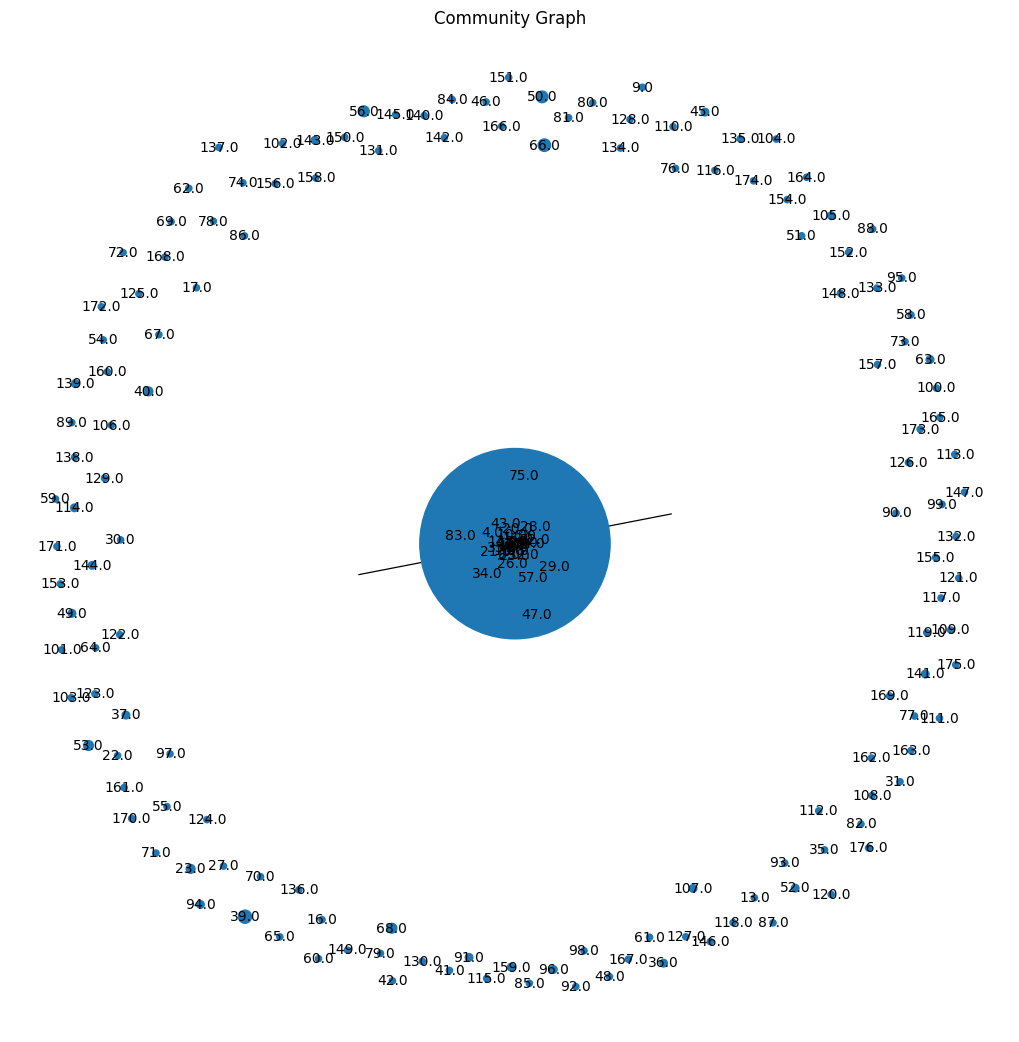

In [44]:
# יצירת גרף חדש שבו כל קודקוד הוא קהילה
community_graph = nx.Graph()

# הוספת צמתים לגרף החדש, כאשר כל צומת מייצג קהילה
for comm_id, group in nodes_data.groupby('community'):
    community_graph.add_node(comm_id, size=len(group))

# הוספת קשתות בין הקהילות על בסיס הקשרים ברשת המקורית
for u, v in G.edges():
    comm_u = partition_louvain[u]
    comm_v = partition_louvain[v]
    if comm_u != comm_v:
        if community_graph.has_edge(comm_u, comm_v):
            community_graph[comm_u][comm_v]['weight'] += 1
        else:
            community_graph.add_edge(comm_u, comm_v, weight=1)

# הצגת הגרף של הקהילות
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(community_graph, k=0.15)
nx.draw(community_graph, pos, with_labels=True, node_size=[community_graph.nodes[n]['size'] * 10 for n in community_graph.nodes()], font_size=10, width=[community_graph[u][v]['weight'] * 0.1 for u, v in community_graph.edges()])
plt.title("Community Graph")
plt.show()


In [45]:
# חישוב Betweenness centrality עבור כל צומת
betweenness_centrality = nx.betweenness_centrality(G)
nodes_data['betweenness'] = nodes_data['spotify_id'].map(betweenness_centrality)

# חישוב Closeness centrality עבור כל צומת
closeness_centrality = nx.closeness_centrality(G)
nodes_data['closeness'] = nodes_data['spotify_id'].map(closeness_centrality)

# הצגת הצמתים עם Betweenness ו-Closeness הגבוה ביותר בכל קהילה
for comm_id, group in nodes_data.groupby('community'):
    print(f"\nCommunity {comm_id}:")
    print(group[['name', 'followers', 'betweenness', 'closeness']].sort_values(by='betweenness', ascending=False).head(5))



Community 0.0:
                 name  followers  betweenness  closeness
8639              Guè  1982665.0     0.011523   0.254142
18735     Traditional    49046.0     0.010363   0.215444
16506   Sfera Ebbasta  4975040.0     0.007898   0.259000
18142  Andrea Bocelli  2221093.0     0.004989   0.242060
8931        Sick Luke   190977.0     0.003617   0.229994

Community 1.0:
             name  followers  betweenness  closeness
10090  Kool Savas   552386.0     0.007136   0.231897
1324   Farid Bang   816132.0     0.006933   0.248267
4206    Eko Fresh   303100.0     0.005588   0.230845
233       Olexesh   858401.0     0.005068   0.232539
1        Kontra K  1999676.0     0.004499   0.242450

Community 2.0:
                   name   followers  betweenness  closeness
7897            Farruko  13975050.0     0.019176   0.272118
18411          J Balvin  35224872.0     0.015873   0.278515
11600           Pitbull   9555658.0     0.015774   0.276754
9919         Juan Magán   1701180.0     0.011337   0

In [46]:
# שמירת הקובץ עם המידע על הקהילות
nodes_data.to_excel('nodes_with_communities_and_centrality.xlsx', index=False)

# שמירת הגרף של הקהילות
nx.write_gml(community_graph, 'community_graph.gml')


In [47]:
import pandas as pd

# טעינת הנתונים מהקובץ
nodes_data = pd.read_excel('nodes_with_communities_and_centrality.xlsx')

# הצגת מספר רשומות והעמודות שבקובץ
print(nodes_data.shape)
print(nodes_data.columns)


(15540, 10)
Index(['spotify_id', 'name', 'followers', 'popularity', 'genres', 'chart_hits',
       'countries', 'community', 'betweenness', 'closeness'],
      dtype='object')


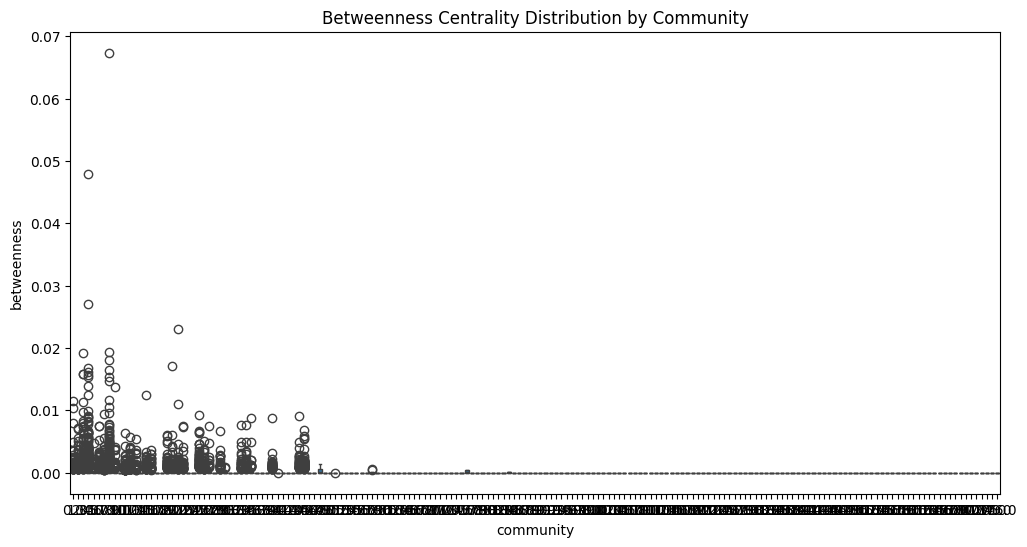

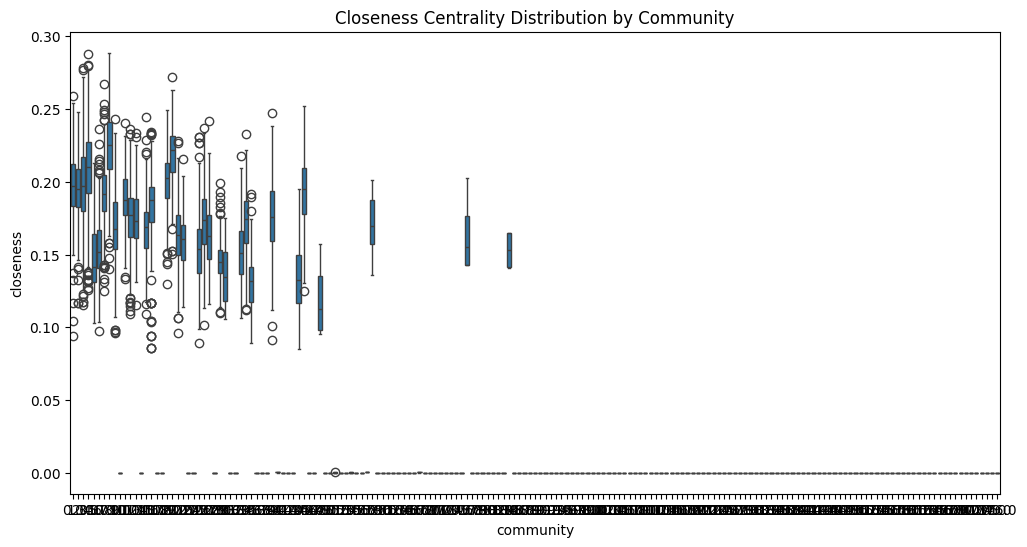

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# יצירת גרף התפלגות מדד Betweenness בתוך כל קהילה
plt.figure(figsize=(12, 6))
sns.boxplot(x='community', y='betweenness', data=nodes_data)
plt.title("Betweenness Centrality Distribution by Community")
plt.show()

# יצירת גרף התפלגות מדד Closeness בתוך כל קהילה
plt.figure(figsize=(12, 6))
sns.boxplot(x='community', y='closeness', data=nodes_data)
plt.title("Closeness Centrality Distribution by Community")
plt.show()


In [50]:
# זיהוי קהילות עם ערכי Closeness גבוהים ונמוכים
high_closeness_communities = nodes_data.groupby('community')['closeness'].mean().nlargest(5)
low_closeness_communities = nodes_data.groupby('community')['closeness'].mean().nsmallest(5)

print("Top 5 communities with highest average closeness:")
print(high_closeness_communities)

print("\nTop 5 communities with lowest average closeness:")
print(low_closeness_communities)

# זיהוי הצמתים המובילים בקהילות אלו
top_nodes_in_high_closeness = nodes_data[nodes_data['community'].isin(high_closeness_communities.index)]
top_nodes_in_low_closeness = nodes_data[nodes_data['community'].isin(low_closeness_communities.index)]

print("\nTop nodes in high closeness communities:")
print(top_nodes_in_high_closeness[['spotify_id', 'name', 'closeness', 'community']].head(10))

print("\nTop nodes in low closeness communities:")
print(top_nodes_in_low_closeness[['spotify_id', 'name', 'closeness', 'community']].head(10))


Top 5 communities with highest average closeness:
community
7.0     0.223650
19.0    0.217725
3.0     0.209092
18.0    0.200464
2.0     0.197932
Name: closeness, dtype: float64

Top 5 communities with lowest average closeness:
community
9.0     0.000082
13.0    0.000082
16.0    0.000082
17.0    0.000082
22.0    0.000082
Name: closeness, dtype: float64

Top nodes in high closeness communities:
                spotify_id                name  closeness  community
2   3dXC1YPbnQPsfHPVkm1ipj  Christopher Martin   0.221276        7.0
5   3TG1RXLaEhHz5SIPMWahit              Nehuda   0.193070        2.0
13  2NUz5P42WqkxilbI8ocN76         Vybz Kartel   0.249603        7.0
15  6M2wZ9GZgrQXHCFfjv46we            Dua Lipa   0.260518        3.0
19  2bPh6UXbS7wZ7tyN35kFEG        Artistic Raw   0.220661       18.0
24  5Matrg5du62bXwer29cU5T   Benny The Butcher   0.239225        7.0
26  4e0nWw2r4BoQSKPQ2zpU13          Ray Dalton   0.227709        3.0
29  2HmmA3GhP0xsbRUiDllJUn          Pep & Rash   0.2


Community Metrics (Closeness and Betweenness):
           closeness  betweenness
community                        
7.0         0.223650     0.000697
19.0        0.217725     0.000441
3.0         0.209092     0.000456
18.0        0.200464     0.000295
2.0         0.197932     0.000341
0.0         0.196379     0.000299
1.0         0.194264     0.000293
44.0        0.193433     0.000282
6.0         0.192190     0.000237
10.0        0.188336     0.000218


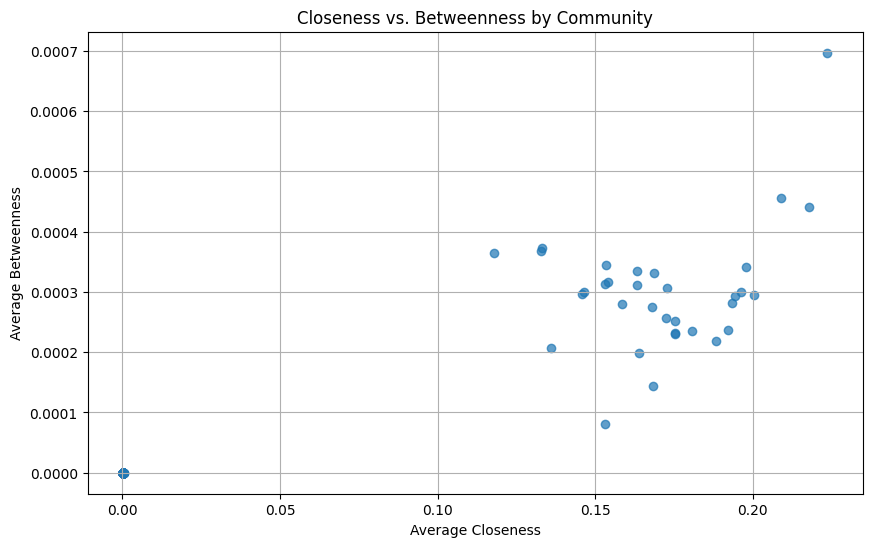

In [51]:
# ניתוח ממוצע ה-Closeness וה-Betweenness עבור כל קהילה
community_metrics = nodes_data.groupby('community').agg({
    'closeness': 'mean',
    'betweenness': 'mean'
}).sort_values(by='closeness', ascending=False)

print("\nCommunity Metrics (Closeness and Betweenness):")
print(community_metrics.head(10))  # הצגת 10 הקהילות הראשונות

# הצגת גרף השוואה בין Closeness ל-Betweenness
plt.figure(figsize=(10, 6))
plt.scatter(community_metrics['closeness'], community_metrics['betweenness'], alpha=0.7)
plt.title('Closeness vs. Betweenness by Community')
plt.xlabel('Average Closeness')
plt.ylabel('Average Betweenness')
plt.grid(True)
plt.show()


In [52]:
# זיהוי קהילות בולטות עם תכונות מיוחדות (למשל, קהילות עם ערכי Closeness גבוהים מאוד או נמוכים מאוד)
significant_communities = community_metrics[
    (community_metrics['closeness'] > 0.2) |
    (community_metrics['betweenness'] > 0.01)
]

print("\nSignificant Communities with High Closeness or Betweenness:")
print(significant_communities)

# בחינת הצמתים המובילים בקהילות אלו
for community_id in significant_communities.index:
    print(f"\nTop nodes in community {community_id}:")
    top_nodes = nodes_data[nodes_data['community'] == community_id].nlargest(5, 'closeness')
    print(top_nodes[['spotify_id', 'name', 'closeness', 'betweenness']])



Significant Communities with High Closeness or Betweenness:
           closeness  betweenness
community                        
7.0         0.223650     0.000697
19.0        0.217725     0.000441
3.0         0.209092     0.000456
18.0        0.200464     0.000295

Top nodes in community 7.0:
                   spotify_id            name  closeness  betweenness
15346  7hJcb9fa4alzcOq3EaNPoG      Snoop Dogg   0.288677     0.067372
12302  6vXTefBL93Dj5IqAWq6OTv  French Montana   0.280713     0.014752
5172   3Isy6kedDrgPYoTS1dazA9       Sean Paul   0.279320     0.011683
6463   738wLrAtLtCtFOLvQBXOXp     Major Lazer   0.277410     0.019288
13091  5LHRHt1k9lMyONurDHEdrp            Tyga   0.277250     0.018013

Top nodes in community 19.0:
                   spotify_id          name  closeness  betweenness
11207  6eUKZXaKkcviH0Ku9w2n3V    Ed Sheeran   0.271953     0.017057
1327   2ExGrw6XpbtUAJHTLtUXUD  Stefflon Don   0.263089     0.003322
10844  4TAoP0f9OuWZUesao43xUW       Mr Eazi   0.2623

In [54]:
import pandas as pd

# טעינת נתוני הצמתים המעודכנים עם קהילות ומדדי מרכזיות
nodes_data = pd.read_excel('nodes_with_communities_and_centrality.xlsx')

# פונקציה לניתוח התפלגות הז'אנרים בתוך קהילות משמעותיות
def analyze_genre_distribution(community_id):
    community_data = nodes_data[nodes_data['community'] == community_id]
    genre_list = community_data['genres'].explode()
    genre_distribution = genre_list.value_counts()
    print(f"Genre Distribution in Community {community_id}:\n{genre_distribution}\n")

# פונקציה לניתוח התפלגות גיאוגרפית בתוך קהילות משמעותיות
def analyze_geographic_distribution(community_id):
    community_data = nodes_data[nodes_data['community'] == community_id]
    country_list = community_data['countries'].explode()
    country_distribution = country_list.value_counts()
    print(f"Geographic Distribution in Community {community_id}:\n{country_distribution}\n")

# ניתוח קהילות משמעותיות
significant_communities = [7.0, 19.0, 3.0, 18.0]

for community_id in significant_communities:
    analyze_genre_distribution(community_id)
    analyze_geographic_distribution(community_id)


Genre Distribution in Community 7.0:
genres
['dance pop', 'pop']                                                                                                                      8
['pop rap']                                                                                                                               7
['j-pop']                                                                                                                                 5
['hip hop', 'rap']                                                                                                                        5
['social media pop']                                                                                                                      4
                                                                                                                                         ..
['canadian pop', 'canadian rock', 'neon pop punk', 'pop quebecois', 'pop rock']                                     

Collaboration patterns within Community 7.0:
Number of nodes: 826
Number of edges: 7002
Average degree: 16.953995157384988


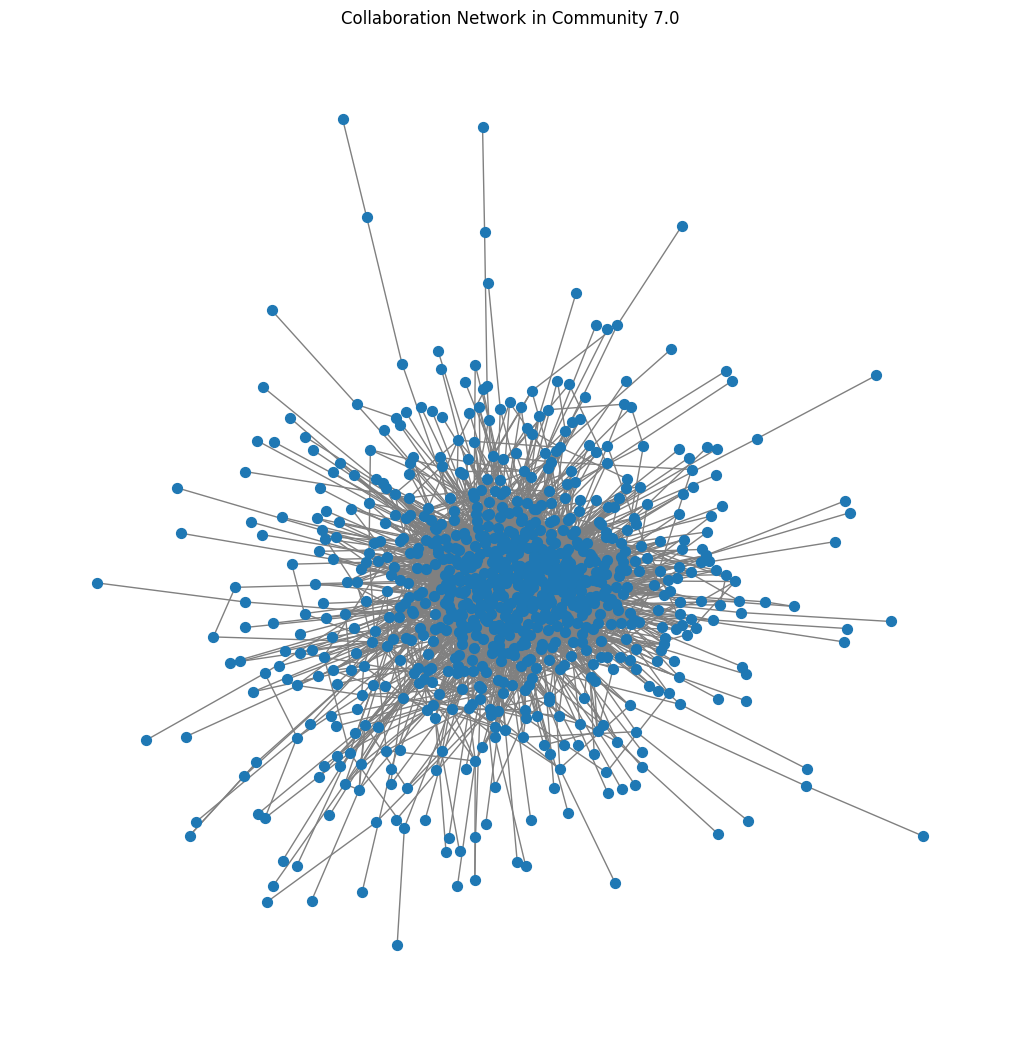

Collaboration patterns within Community 19.0:
Number of nodes: 197
Number of edges: 1120
Average degree: 11.370558375634518


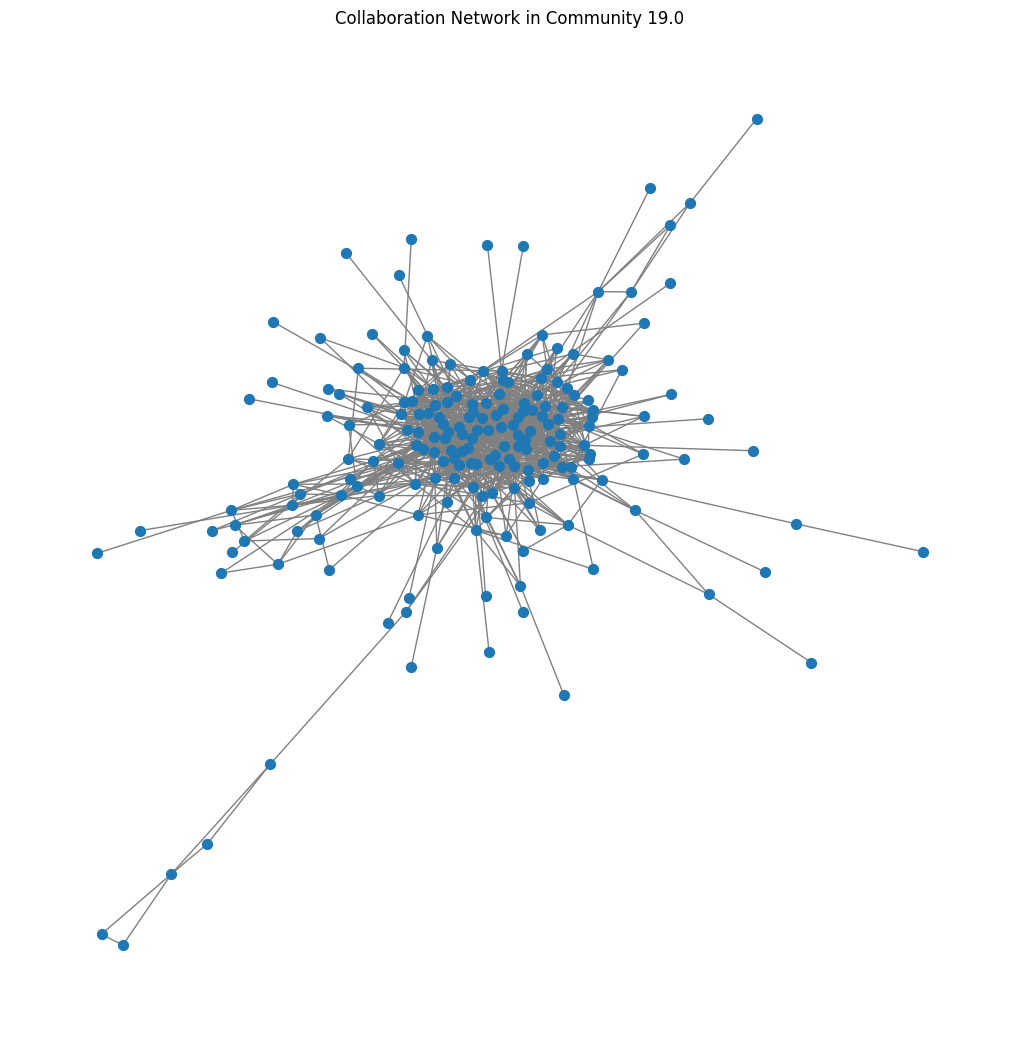

Collaboration patterns within Community 3.0:
Number of nodes: 1873
Number of edges: 8859
Average degree: 9.459690336358783


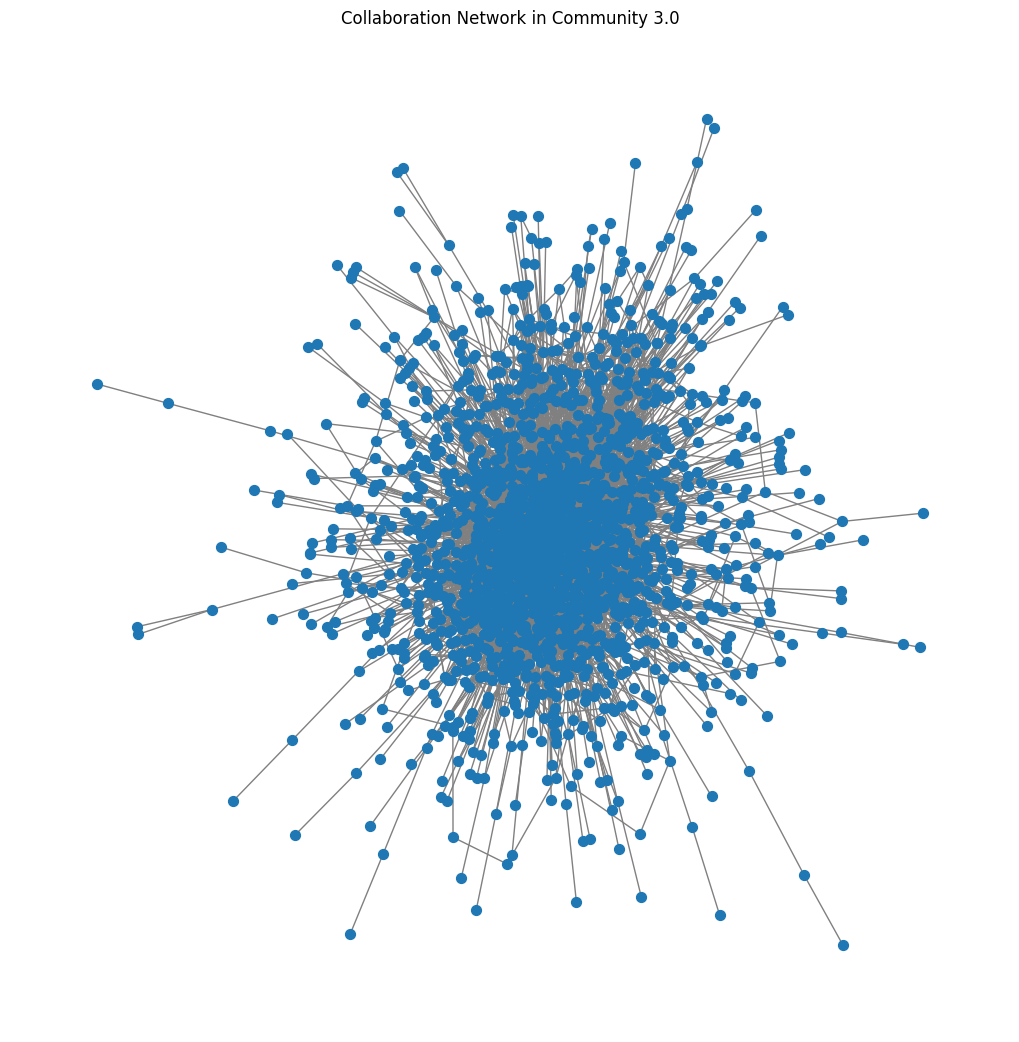

Collaboration patterns within Community 18.0:
Number of nodes: 345
Number of edges: 2861
Average degree: 16.58550724637681


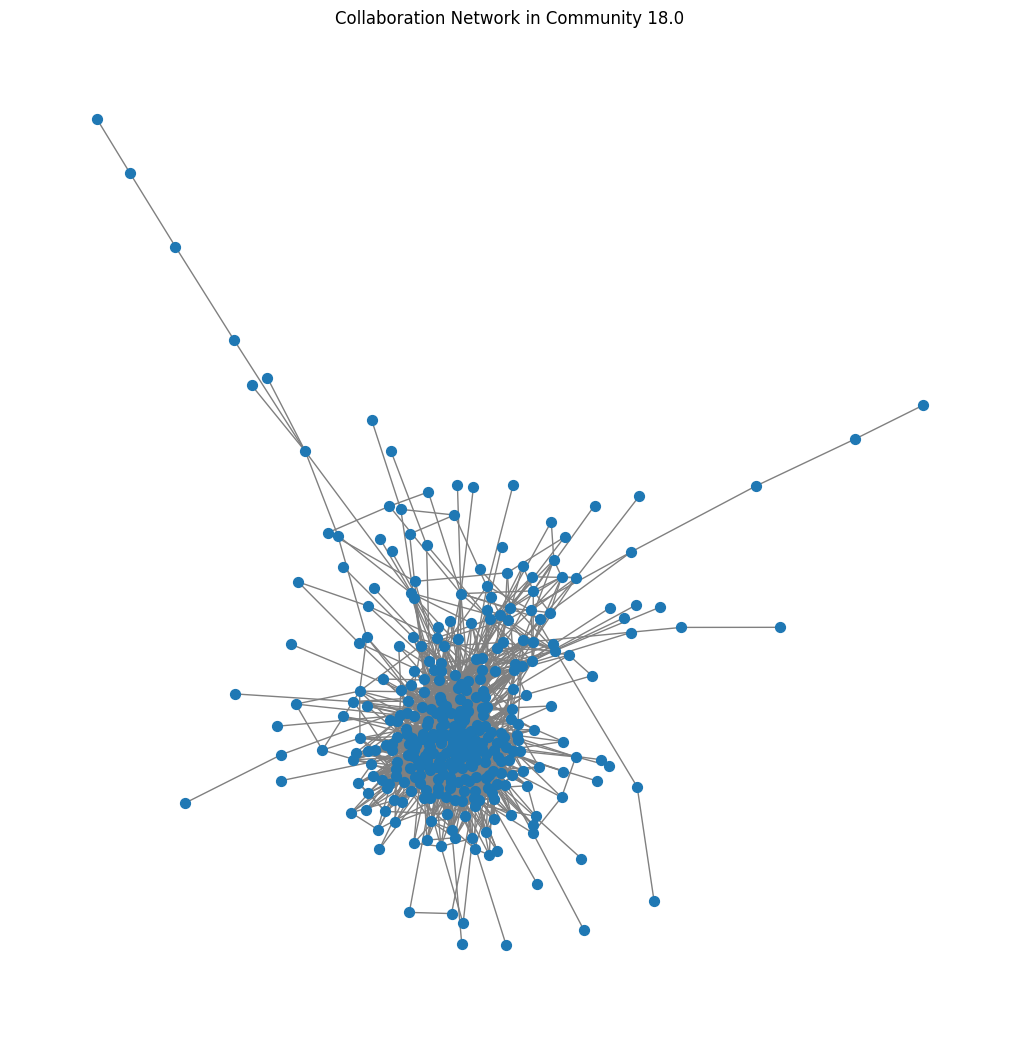

In [55]:
import networkx as nx
import matplotlib.pyplot as plt



def analyze_collaboration_patterns(community_id):
    community_nodes = nodes_data[nodes_data['community'] == community_id]['spotify_id']
    subgraph = G.subgraph(community_nodes)
    print(f"Collaboration patterns within Community {community_id}:")
    print(f"Number of nodes: {subgraph.number_of_nodes()}")
    print(f"Number of edges: {subgraph.number_of_edges()}")
    print(f"Average degree: {sum(dict(subgraph.degree()).values()) / subgraph.number_of_nodes()}")

  
    plt.figure(figsize=(10, 10))
    nx.draw(subgraph, with_labels=False, node_size=50, edge_color='gray')
    plt.title(f"Collaboration Network in Community {community_id}")
    plt.show()

# ניתוח קהילות משמעותיות
for community_id in significant_communities:
    analyze_collaboration_patterns(community_id)


Impact on Community 7.0 after removing top closeness nodes:
Original size of largest connected component: 826
Size of largest connected component after removal: 11916


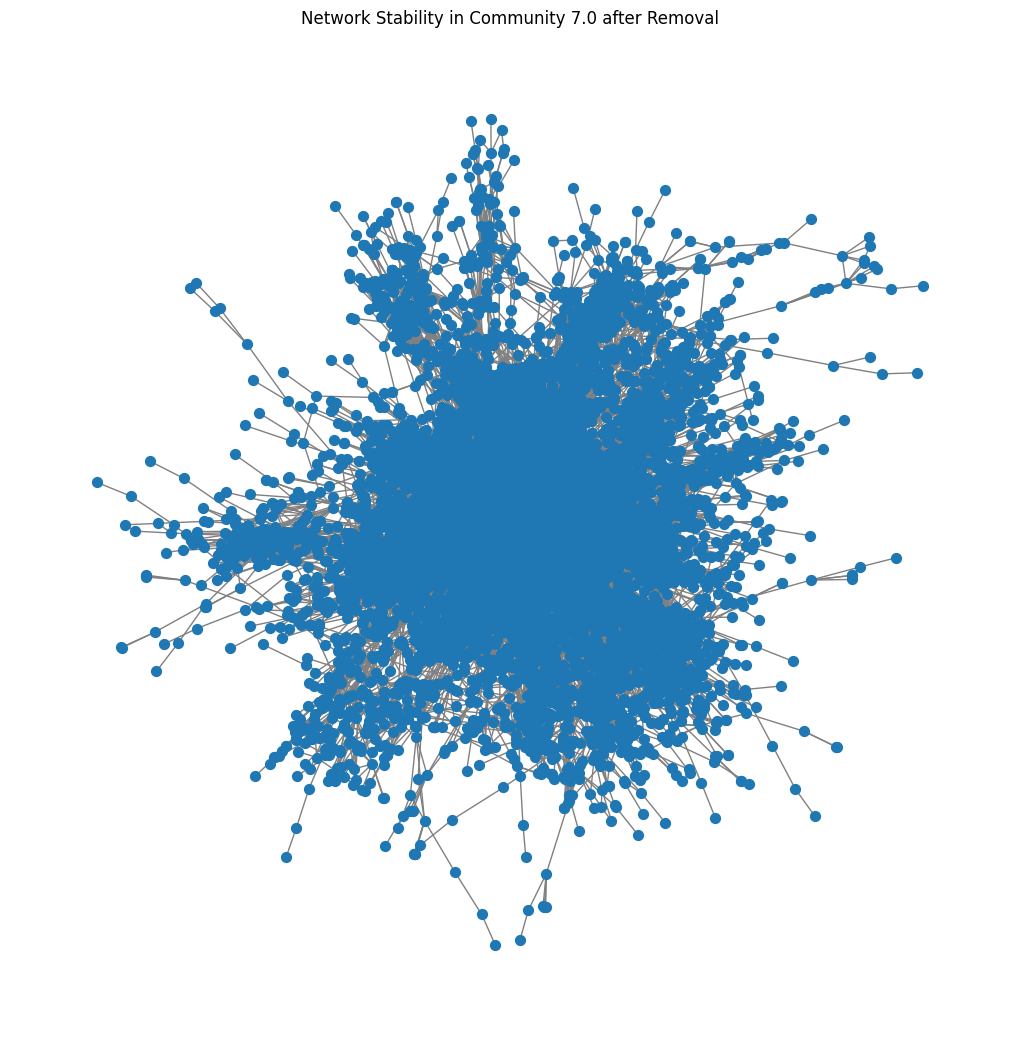

Impact on Community 19.0 after removing top closeness nodes:
Original size of largest connected component: 197
Size of largest connected component after removal: 11918


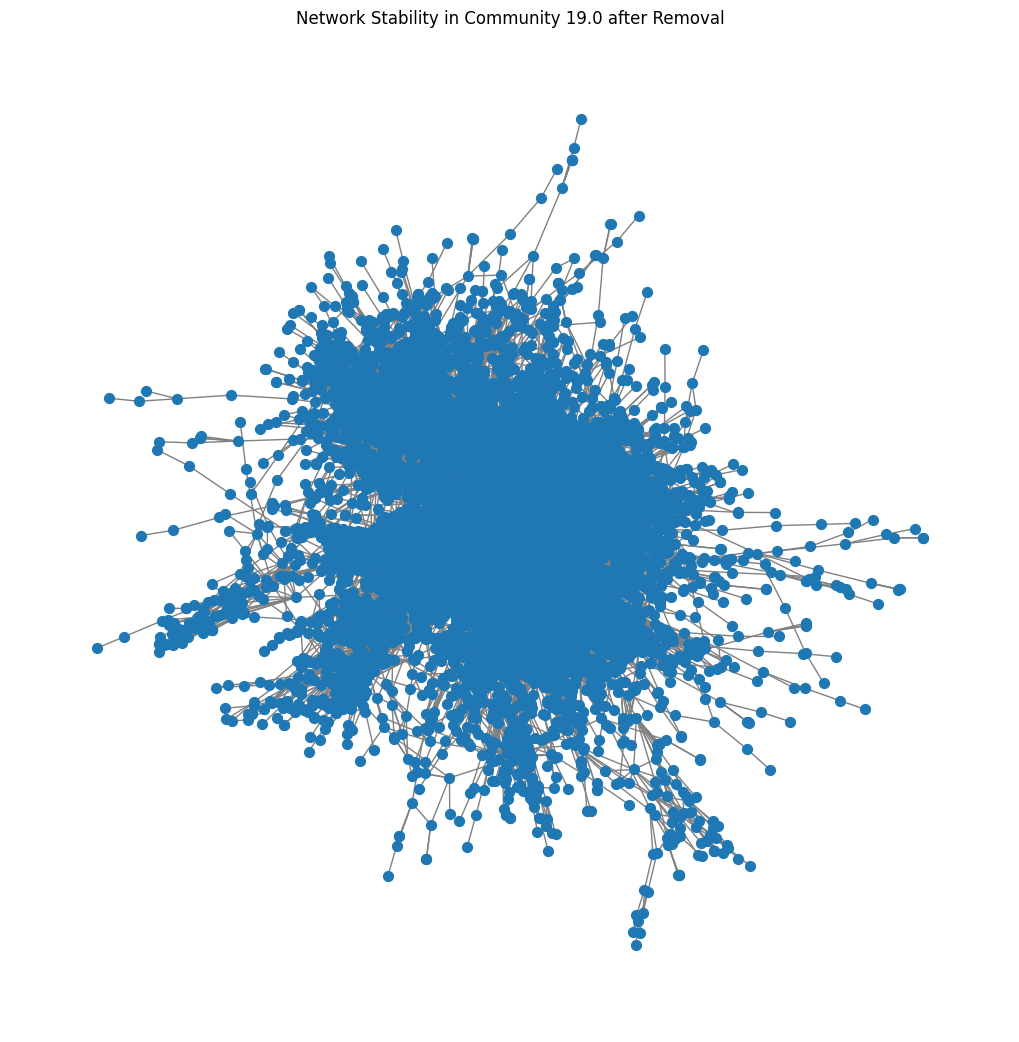

Impact on Community 3.0 after removing top closeness nodes:
Original size of largest connected component: 1873
Size of largest connected component after removal: 11908


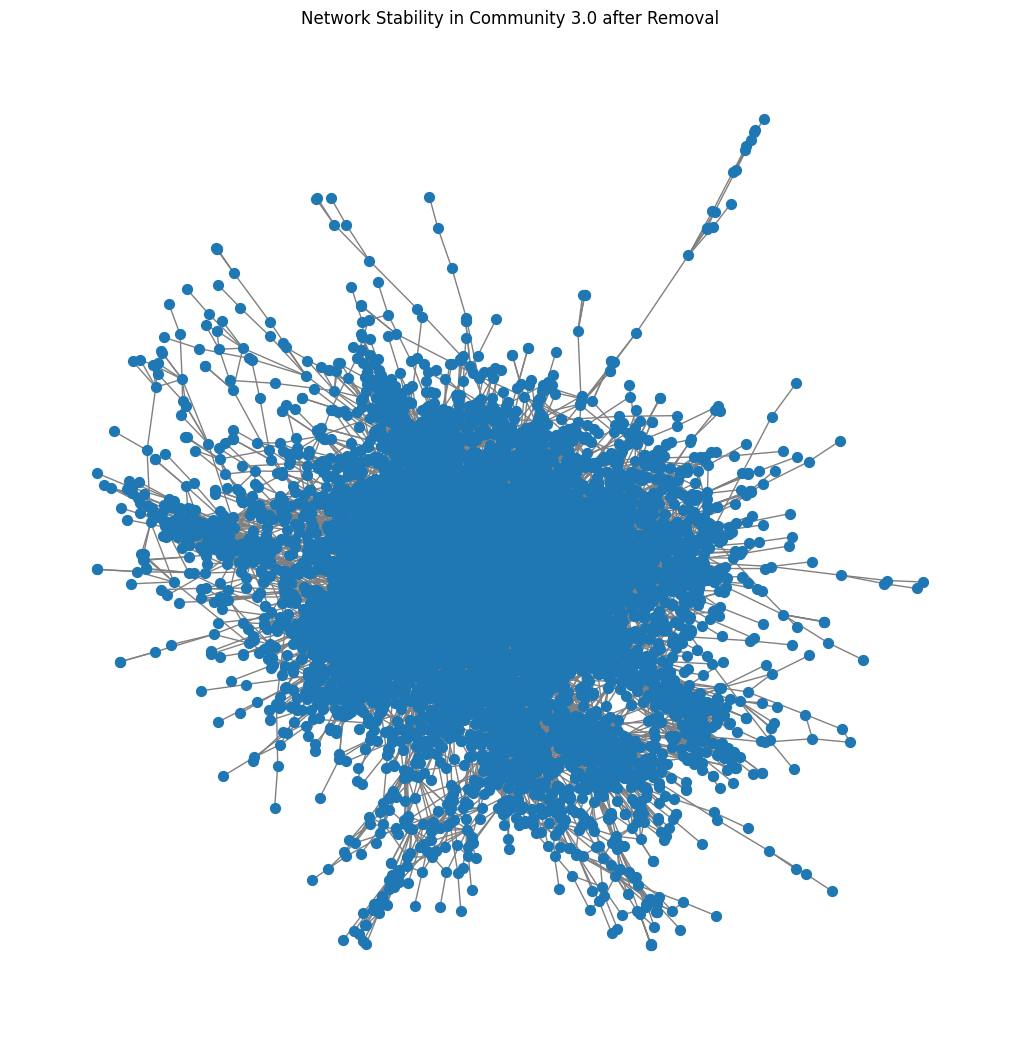

Impact on Community 18.0 after removing top closeness nodes:
Original size of largest connected component: 345
Size of largest connected component after removal: 11917


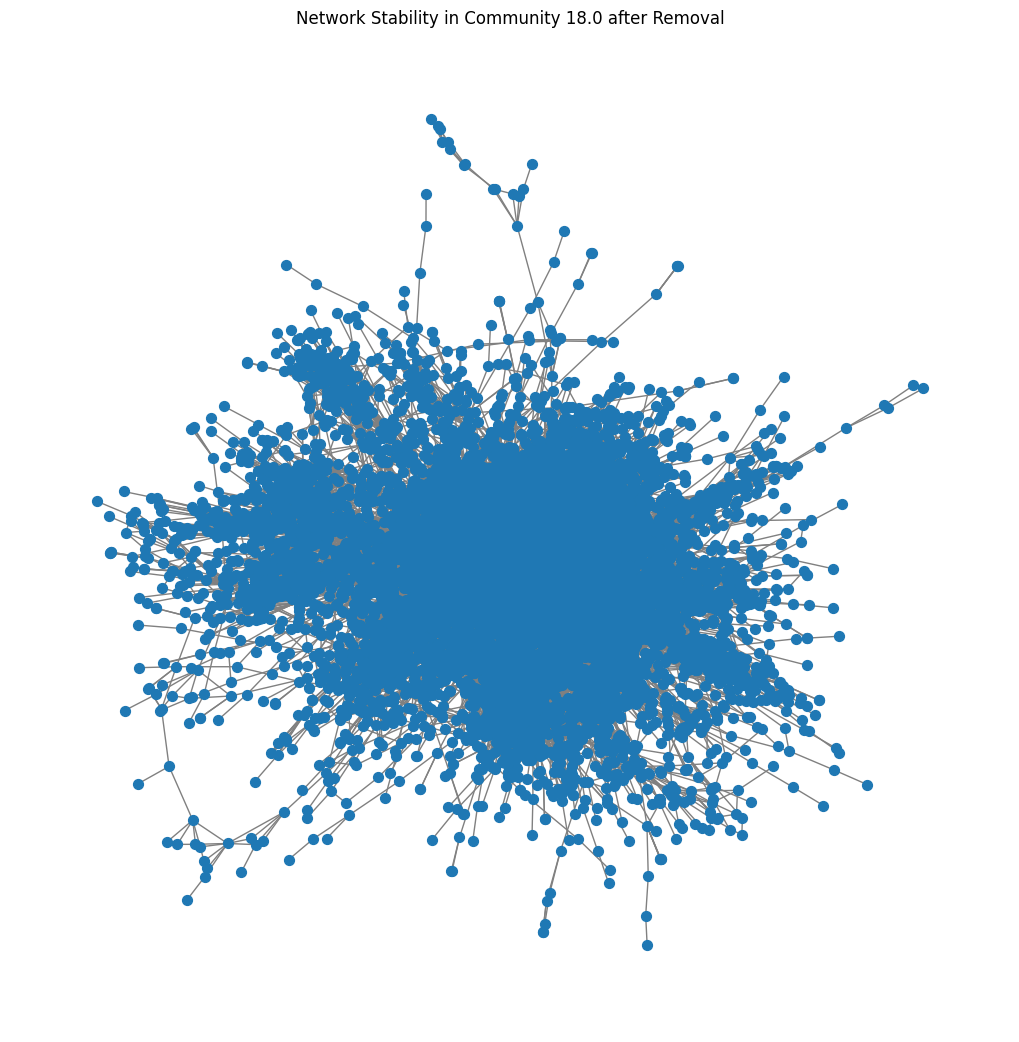

In [56]:
def evaluate_network_stability(community_id, centrality_metric='closeness'):
    community_data = nodes_data[nodes_data['community'] == community_id]
    sorted_community = community_data.sort_values(by=centrality_metric, ascending=False)
    top_nodes = sorted_community['spotify_id'].head(5)  # בחירת 5 הצמתים המובילים

     # הסרת הצמתים המובילים והערכת הרשת
    G_copy = G.copy()
    G_copy.remove_nodes_from(top_nodes)

    # בדיקת קישוריות
    connected_components = list(nx.connected_components(G_copy))
    largest_cc = max(connected_components, key=len)

    print(f"Impact on Community {community_id} after removing top {centrality_metric} nodes:")
    print(f"Original size of largest connected component: {G.subgraph(community_data['spotify_id']).number_of_nodes()}")
    print(f"Size of largest connected component after removal: {len(largest_cc)}")

       # ויזואליזציה של הרשת הנותרת
    plt.figure(figsize=(10, 10))
    nx.draw(G_copy.subgraph(largest_cc), with_labels=False, node_size=50, edge_color='gray')
    plt.title(f"Network Stability in Community {community_id} after Removal")
    plt.show()

# ניתוח קהילות משמעותיות על בסיס מדד המרכזיות Closeness
for community_id in significant_communities:
    evaluate_network_stability(community_id, centrality_metric='closeness')


In [57]:
import pandas as pd


nodes_data = pd.read_excel('nodes_with_communities_and_centrality.xlsx')

# ניתוח לפי התפלגות של ז'אנר בקהילות
def analyze_genre_distribution(community_id):
    community_data = nodes_data[nodes_data['community'] == community_id]
    genre_list = community_data['genres'].explode()
    genre_distribution = genre_list.value_counts()
    print(f"Genre Distribution in Community {community_id}:\n{genre_distribution}\n")

# ניתוח התפלגות גיאוגרפי בקהילות
def analyze_geographic_distribution(community_id):
    community_data = nodes_data[nodes_data['community'] == community_id]
    country_list = community_data['countries'].explode()
    country_distribution = country_list.value_counts()
    print(f"Geographic Distribution in Community {community_id}:\n{country_distribution}\n")

# ניתוח קהילות משמעותיות
significant_communities = [7.0, 19.0, 3.0, 18.0]

for community_id in significant_communities:
    analyze_genre_distribution(community_id)
    analyze_geographic_distribution(community_id)


Genre Distribution in Community 7.0:
genres
['dance pop', 'pop']                                                                                                                      8
['pop rap']                                                                                                                               7
['j-pop']                                                                                                                                 5
['hip hop', 'rap']                                                                                                                        5
['social media pop']                                                                                                                      4
                                                                                                                                         ..
['canadian pop', 'canadian rock', 'neon pop punk', 'pop quebecois', 'pop rock']                                     


Collaboration patterns within Community 7.0:
Number of nodes: 826
Number of edges: 7002
Average degree: 16.953995157384988


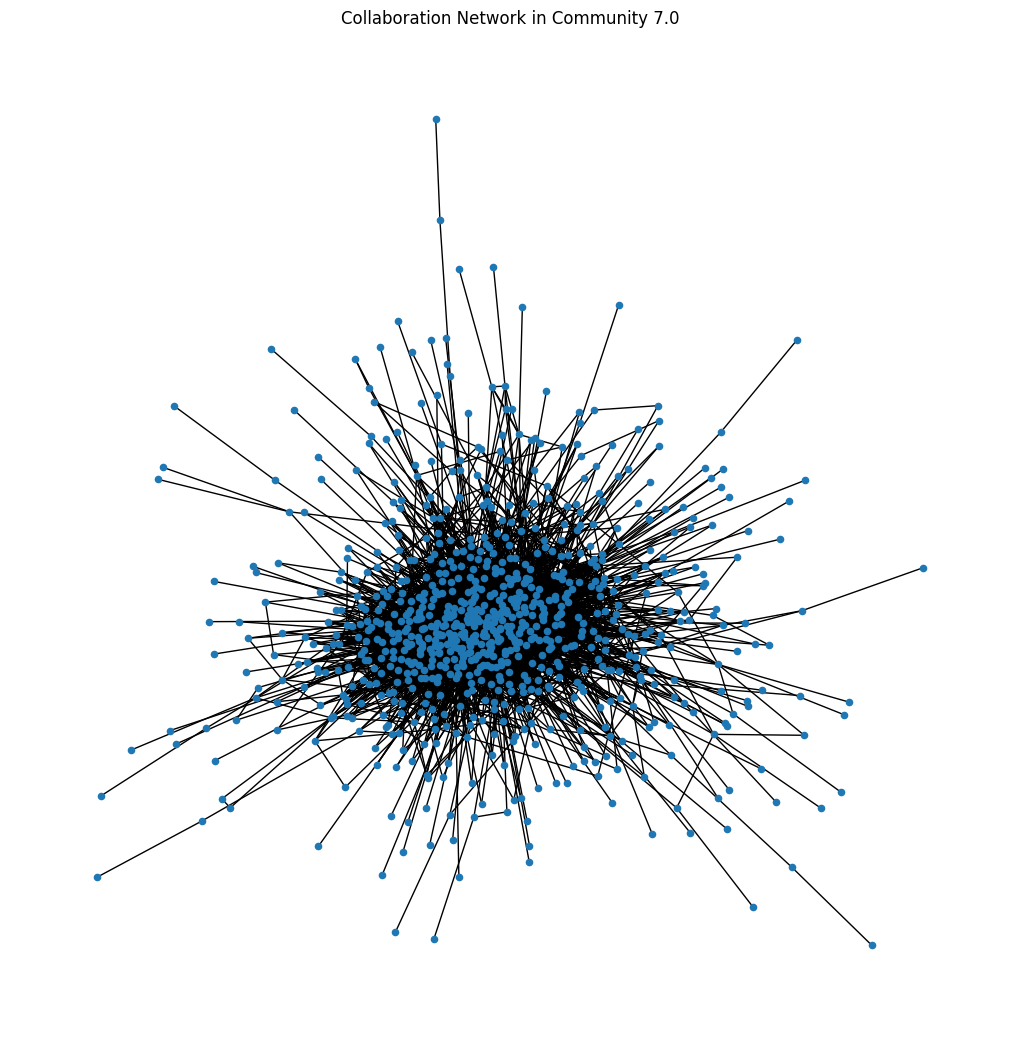


Genre Distribution in Community 7.0:
genres
['dance pop', 'pop']                                                                                                                      8
['pop rap']                                                                                                                               7
['j-pop']                                                                                                                                 5
['hip hop', 'rap']                                                                                                                        5
['social media pop']                                                                                                                      4
                                                                                                                                         ..
['canadian pop', 'canadian rock', 'neon pop punk', 'pop quebecois', 'pop rock']                                    

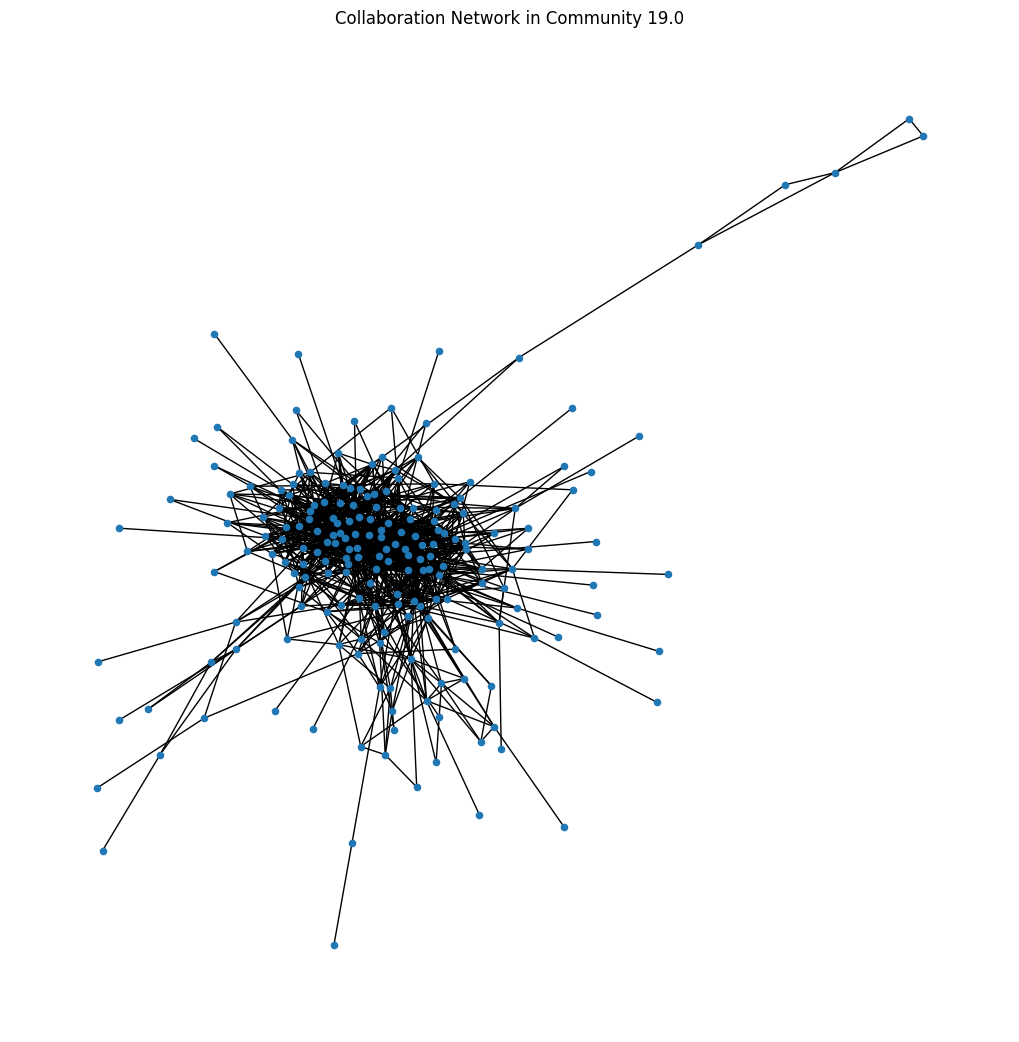


Genre Distribution in Community 19.0:
genres
['uk hip hop']                                                    16
['uk drill', 'uk hip hop']                                        15
['grime', 'uk hip hop']                                            9
['afroswing', 'uk hip hop']                                        6
['nigerian pop']                                                   4
                                                                  ..
['dance pop', 'grime', 'uk pop']                                   1
['melodic drill', 'uk alternative hip hop']                        1
['bassline', 'grime', 'instrumental grime']                        1
['grime']                                                          1
['afropop', 'azontobeats', 'nigerian hip hop', 'nigerian pop']     1
Name: count, Length: 137, dtype: int64

Geographic Distribution in Community 19.0:
countries
gb                                            55
ie, gb                                        27
za  

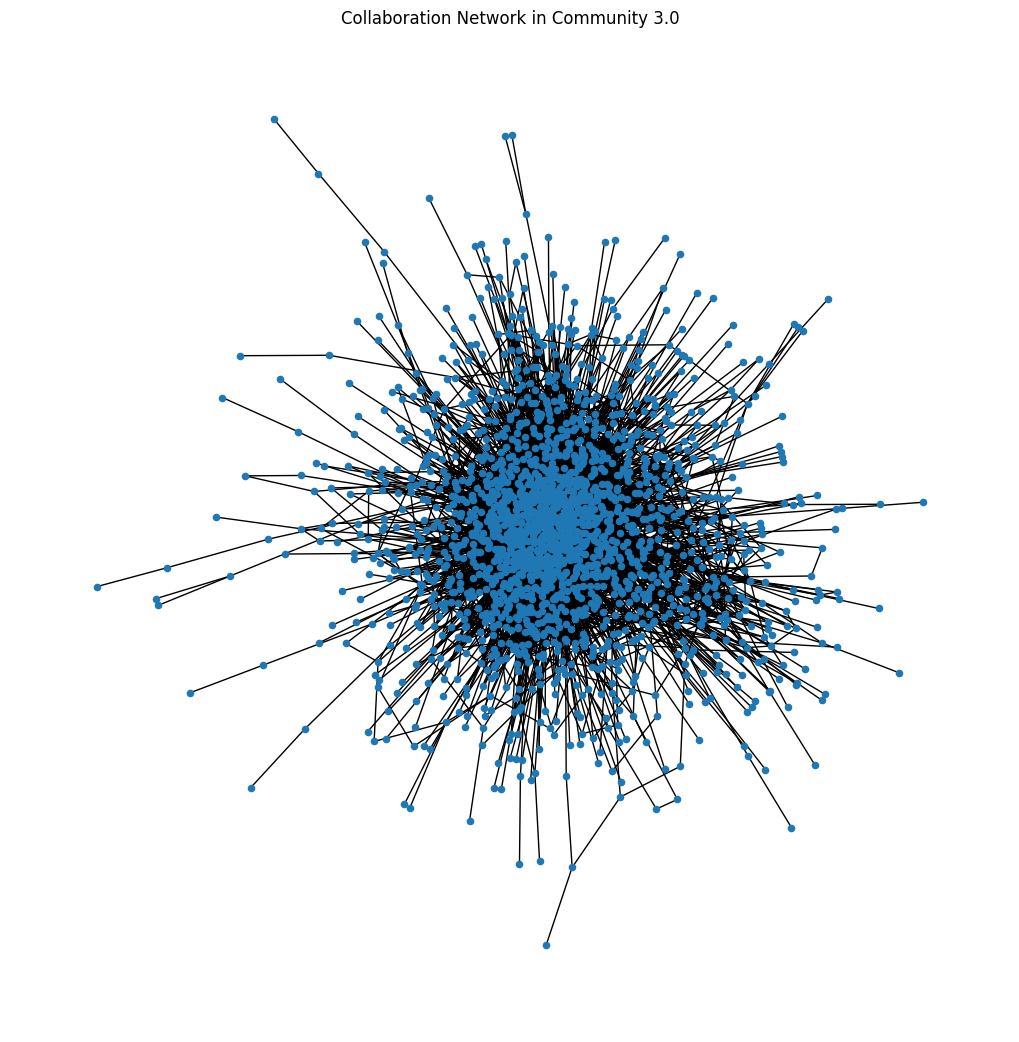


Genre Distribution in Community 3.0:
genres
['contemporary country', 'country', 'country road']                                                 21
['norwegian pop']                                                                                   16
['uk pop']                                                                                          14
['pop edm']                                                                                         13
['k-pop', 'k-pop boy group']                                                                        12
                                                                                                    ..
['canadian indie', 'canadian rock', 'hamilton on indie']                                             1
['underground hip hop']                                                                              1
['boy band']                                                                                         1
['dance pop', 'deep groove h

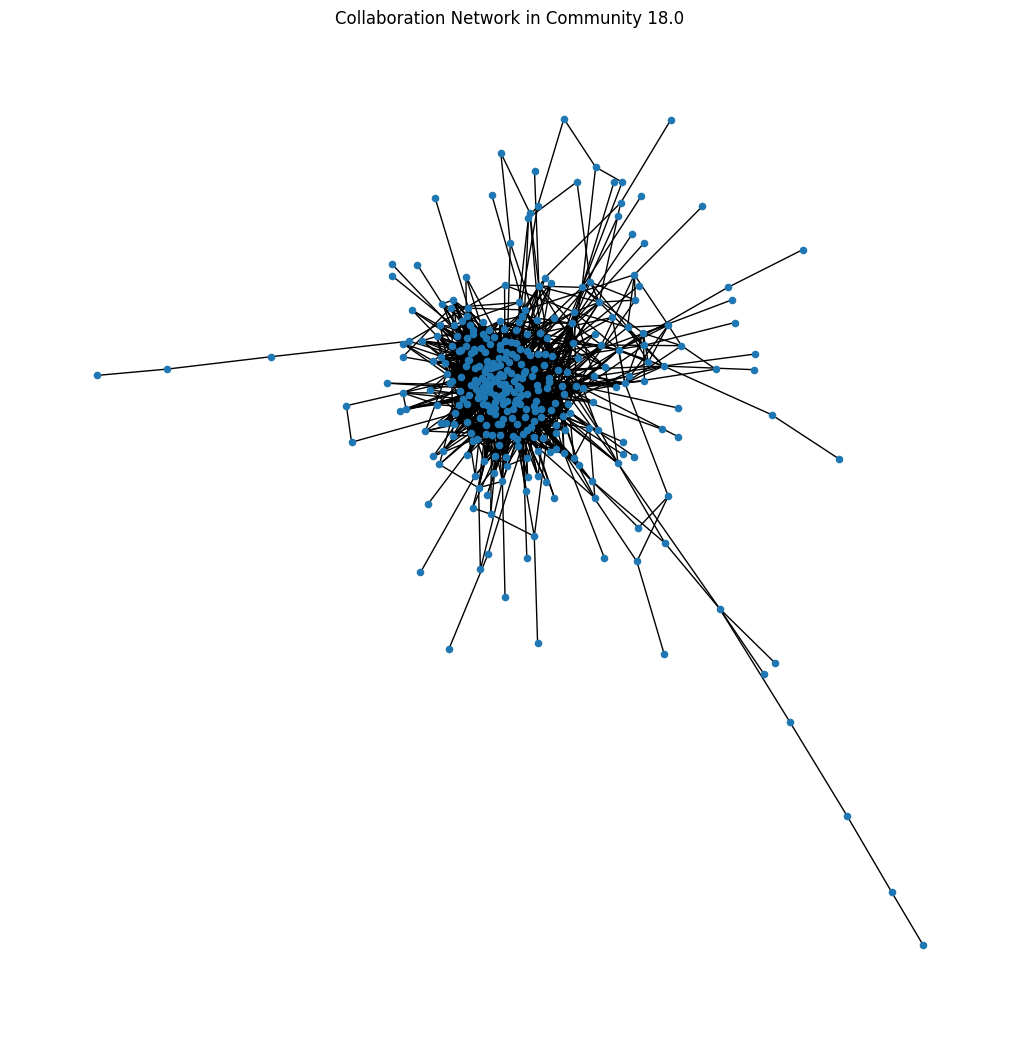


Genre Distribution in Community 18.0:
genres
['dutch hip hop', 'dutch rap pop']                                           69
['dutch hip hop']                                                            49
['dutch pop']                                                                23
['dutch rap pop']                                                            18
['dutch hip hop', 'dutch pop', 'dutch rap pop']                              17
                                                                             ..
['kleinkunst']                                                                1
['new romantic', 'new wave', 'proto-techno', 'synthpop', 'zolo']              1
['dutch hip hop', 'dutch rap pop', 'surinamese pop']                          1
['basshall', 'dutch hip hop', 'dutch pop', 'dutch rap pop', 'moombahton']     1
['dutch hip hop', 'thrash core']                                              1
Name: count, Length: 109, dtype: int64

Geographic Distribution in Communi

In [58]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# קהילות עיקריות שזוהו בשלבים הקודמים
significant_communities = [7.0, 19.0, 3.0, 18.0]

# פונקציה מורחבת לניתוח קהילות
def analyze_community(G, nodes_data, community_id):
    
    community_nodes = nodes_data[nodes_data['community'] == community_id]
    community_subgraph = G.subgraph(community_nodes['spotify_id'].tolist())

    
    print(f"\nCollaboration patterns within Community {community_id}:")
    print(f"Number of nodes: {community_subgraph.number_of_nodes()}")
    print(f"Number of edges: {community_subgraph.number_of_edges()}")
    print(f"Average degree: {sum(dict(community_subgraph.degree()).values()) / community_subgraph.number_of_nodes()}")

    
    plt.figure(figsize=(10, 10))
    nx.draw(community_subgraph, node_size=20, with_labels=False)
    plt.title(f"Collaboration Network in Community {community_id}")
    plt.show()

    # התפלגות ג'אנר
    genre_distribution = community_nodes['genres'].value_counts()
    print(f"\nGenre Distribution in Community {community_id}:\n{genre_distribution}")

    # התפלגות גיאוגרפית
    geo_distribution = community_nodes['countries'].value_counts()
    print(f"\nGeographic Distribution in Community {community_id}:\n{geo_distribution}")

# ניתוח כל קהילה משמעותית
for community_id in significant_communities:
    analyze_community(G, nodes_data, community_id)


In [59]:
import pandas as pd



def analyze_genre_distribution(nodes_data, community_id):
    community_data = nodes_data[nodes_data['community'] == community_id]
    genre_distribution = community_data['genres'].value_counts()
    print(f"Genre Distribution in Community {community_id}:")
    print(genre_distribution)

def analyze_geographic_distribution(nodes_data, community_id):
    community_data = nodes_data[nodes_data['community'] == community_id]
    geographic_distribution = community_data['countries'].value_counts()
    print(f"Geographic Distribution in Community {community_id}:")
    print(geographic_distribution)

# ניתוח קהילות משמעותיות
for community_id in [7.0, 19.0, 3.0, 18.0]:
    print(f"\nAnalysis for Community {community_id}:")
    analyze_genre_distribution(nodes_data, community_id)
    analyze_geographic_distribution(nodes_data, community_id)



Analysis for Community 7.0:
Genre Distribution in Community 7.0:
genres
['dance pop', 'pop']                                                                                                                      8
['pop rap']                                                                                                                               7
['j-pop']                                                                                                                                 5
['hip hop', 'rap']                                                                                                                        5
['social media pop']                                                                                                                      4
                                                                                                                                         ..
['canadian pop', 'canadian rock', 'neon pop punk', 'pop quebecois', 'pop rock']        